In [141]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from cvfunc import color_threshold, auto_crop, get_bounding_box, get_colors

In [142]:
img = cv2.imread('shrink/East_day105_16Apr2013_S.png')

In [143]:
img_mask = color_threshold(img,[[255,255,255]],[[255,255,255]],invert=True)

In [144]:
colors = get_colors(img)[0][1:-1].tolist()

In [145]:
colors

[[34, 101, 242],
 [92, 92, 92],
 [164, 211, 179],
 [195, 251, 211],
 [197, 255, 216],
 [240, 174, 0]]

In [146]:
img = cv2.bitwise_and(img,img,mask=img_mask.astype(np.uint8))

In [147]:
height,width,channels = img.shape

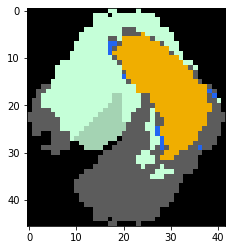

In [148]:
plt.imshow(img)

In [149]:
height,width,channels = img.shape

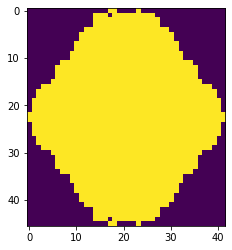

In [150]:
plt.imshow(img_mask)

In [151]:
color_layers = [cv2.bitwise_and(img,img,mask=color_threshold(img,[color],[color]).astype(np.uint8)) for color in colors]

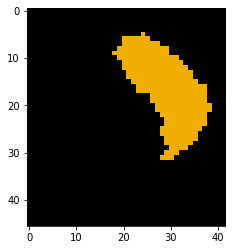

In [152]:
plt.imshow(color_layers[-1])

In [153]:
_,_,H,L = get_bounding_box(img_mask)

In [154]:
def nonzero(n): return img_mask[n,:].nonzero()[0]

In [155]:
def x_left(n): return nonzero(n).min()

In [156]:
def Dx(n): return nonzero(n).max()-nonzero(n).min()

In [157]:
def F(n):
    return np.array([
        [L/Dx(n),0,-L*x_left(n)/Dx(n)],
        [0,1,0]
    ])

In [158]:
def F_inverse(n):
    return np.array([
        [Dx(n)/L,0,x_left(n)],
        [0,1,0]
    ])

In [159]:
def mask_partition(Img,mask,n):
    S = np.zeros_like(mask)
    S[n,:] = 1
    Slice = (mask*S).copy()
    return cv2.bitwise_and(Img,Img,mask=Slice.astype(np.uint8))

In [160]:
layers = [[mask_partition(Img,img_mask,n) for n in range(H+1)] for Img in color_layers]

In [161]:
F_layers = [[cv2.warpAffine(_slice,F(n),(_slice.shape[1],_slice.shape[0])) for n,_slice in enumerate(layer)] for layer in layers]

In [164]:
def merge_slices(slice_list):
    img_total = np.zeros_like(img,dtype=np.uint8)
    for _slice in slice_list:
        mask = color_threshold(_slice,[[0,0,0]],[[0,0,0]],invert=False)
        img_total = cv2.bitwise_and(img_total,img_total,mask=mask.astype(np.uint8))
        img_total = cv2.max(img_total,_slice)
        #img_total = cv2.max(img_total,_slice)
    return img_total

In [165]:
F_color_layers = [merge_slices(layer) for layer in F_layers]

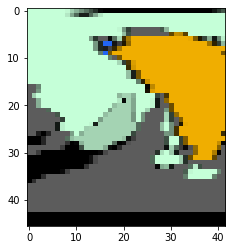

In [166]:
plt.imshow(merge_slices(F_color_layers))

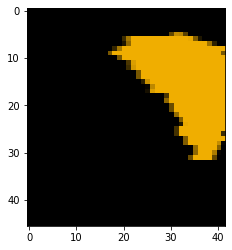

In [167]:
plt.imshow(F_color_layers[-1])

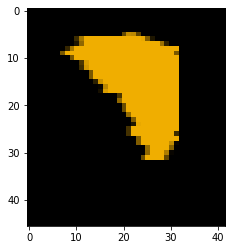

In [168]:
#Moving last color to the left
F_color_layers[-1] = np.roll(F_color_layers[-1],-10,1)
plt.imshow(F_color_layers[-1])

In [169]:
F_img = merge_slices(F_color_layers)

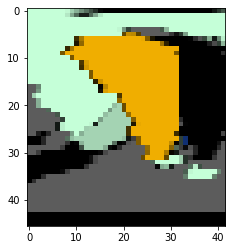

In [170]:
plt.imshow(F_img)

In [171]:
inverse_img_mask = color_threshold(F_img,[[255,255,255]],[[255,255,255]],invert=True)

In [172]:
inverse_layers = [[mask_partition(Img,inverse_img_mask,n) for n in range(H+1)] for Img in F_color_layers]

In [173]:
F_inverse_layers = [[cv2.warpAffine(_slice,F_inverse(n),(_slice.shape[1],_slice.shape[0])) for n,_slice in enumerate(layer)] for layer in inverse_layers]

In [174]:
F_inverse_color_layers = [merge_slices(layer) for layer in F_inverse_layers]

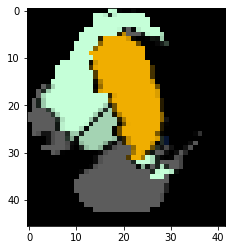

In [175]:
plt.imshow(merge_slices(F_inverse_color_layers))